In [98]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import category_encoders as ce 
    # conda install category_encoders
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
# Завантаження даних
data = pd.read_csv('../datasets/mod_04_hw_train_data.csv')
data.head()

,Name,Phone_Number,Experience,Qualification,University,Role,Cert,Date_Of_Birth,Salary
0,Jennifer Hernandez,120-602-1220,3.0,Msc,Tier2,Mid,Yes,25/08/1972,98000
1,Timothy Walker,840-675-8650,5.0,PhD,Tier2,Senior,Yes,03/12/2013,135500
2,David Duran,556-293-8643,5.0,Msc,Tier2,Senior,Yes,19/07/2002,123500
3,Gloria Ortega,463-559-7474,3.0,Bsc,Tier3,Mid,No,19/02/1970,85000
4,Matthew Steele,968-091-7683,5.0,Bsc,Tier2,Senior,Yes,20/02/1970,111500


In [100]:
valid = pd.read_csv('../datasets/mod_04_hw_valid_data.csv')
valid.head()

,Name,Phone_Number,Experience,Qualification,University,Role,Cert,Date_Of_Birth,Salary
0,Alvaro Johnson,320-636-8883,7,Bsc,Tier1,Senior,No,12/03/1978,109300
1,Austin Powers,903-121-1691,2,Msc,Tier1,Mid,Yes,13/03/1992,84800
2,Joshua Phil,673-972-2453,3,Bsc,Tier3,Mid,Yes,19/02/1988,98900
3,Mirinda Collins,310-364-6925,5,Msc,Tier2,Senior,No,20/03/1989,116500
4,Mustapha Green,401-249-3912,3,PhD,Tier1,Junior,Yes,21/03/1979,75800


In [101]:
# процент пропусків за кожною колонкою.
data.isna().mean().sort_values(ascending=False)

Role             0.012048
Experience       0.008032
Cert             0.008032
Qualification    0.004016
Name             0.000000
Phone_Number     0.000000
University       0.000000
Date_Of_Birth    0.000000
Salary           0.000000
dtype: float64

In [102]:
# Оскільки пропусків тільки до 2% - ми їх видалимо
data = data.dropna()

In [103]:
# ----Зміна категоріальних ознак на числові покращення результату не дало 
# # Зміна 'Role' на int
# role_mapping = {'Junior': 1,'Mid': 2,'Senior': 3}
# data['Role'] = data['Role'].map(role_mapping).astype(int)

# # Зміна 'Qualification' на int
# qualification_mapping = {'Bsc': 1, 'Msc': 2, 'PhD': 3}
# data['Qualification'] = data['Qualification'].map(qualification_mapping).astype(int)

# # Зміна 'University' на int
# u_mapping = {'Tier1': 1, 'Tier2': 2, 'Tier3': 3}
# data['University'] = data['University'].map(u_mapping).astype(int)

In [104]:
# ----Неправдиві дані не дозволили нам використати вік з датасету (деяким людям по 3 роки)
# Одразу отримуємо вік з Date_Of_Birth
# data['Age'] = data['Date_Of_Birth'].apply(lambda x: 2024 - int(x.split('/')[2]))
# data = data.drop('Date_Of_Birth', axis=1)

# valid['Age'] = valid['Date_Of_Birth'].apply(lambda x: 2024 - int(x.split('/')[2]))
# valid = valid.drop('Date_Of_Birth', axis=1)


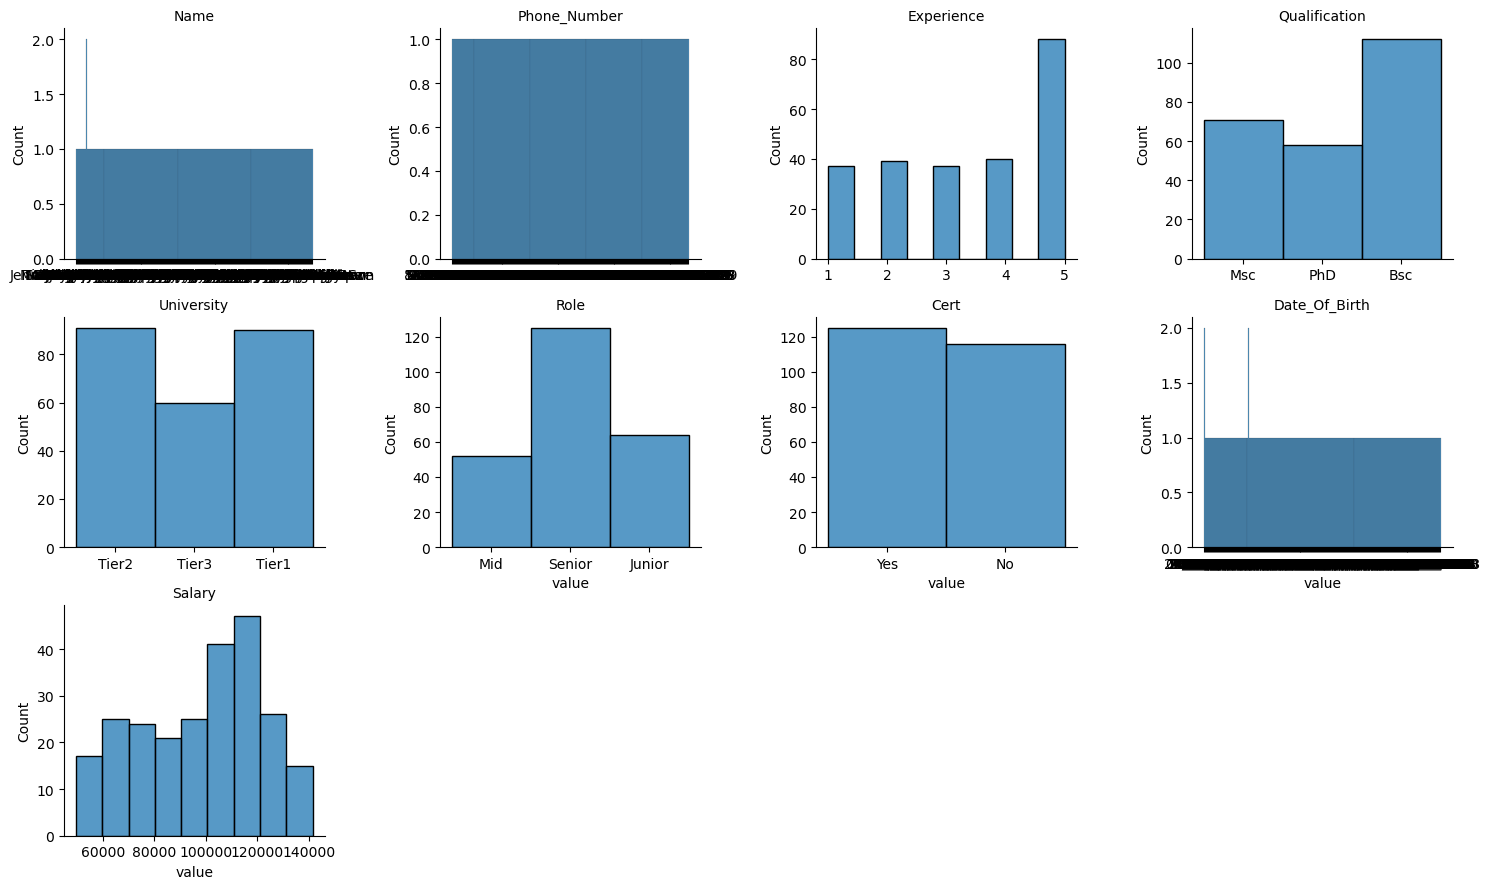

In [105]:
# Розподіли ознак
melted = data.melt()
g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)
g.map(sns.histplot, 'value')
g.set_titles(col_template='{col_name}')
g.tight_layout()
plt.show()

In [106]:
y_train = data.pop("Salary")

In [107]:
# Розбиваємо на числові та категоріальні підмножини:
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

In [108]:
# ----Відновлення пропущених значень не потрібно, оскільки ми їх видалили в рядку 33
# Відновлення пропущених числових значень
# num_imputer = SimpleImputer().set_output(transform='pandas')
# data_num = num_imputer.fit_transform(data_num)

# Відновлення пропущених категоріальних значень:
# cat_imputer = SimpleImputer(
#     strategy='most_frequent').set_output(transform='pandas')
# data_cat = cat_imputer.fit_transform(data_cat)

In [109]:
# ----Отримання коду з номеру телефону, який міг би вказати про регіон проживання не допомогло (майже всі коди різні)
# data_cat['Phone_Code'] = data_cat['Phone_Number'].apply(lambda x: x.split('-')[0])
#valid_cat = valid_cat.drop('Phone_Number'], axis=1)

In [110]:
# Нормалізація числових ознак за допомогою об'єкта StandardScaler або PowerTransformer з пакету sklearn
# scaler = StandardScaler().set_output(transform='pandas')
scaler = PowerTransformer().set_output(transform='pandas')
X_train_num = scaler.fit_transform(data_num)

In [111]:
# Спроба знайти залежність між категоріальними ознаками
from scipy.stats import chi2_contingency

# Функція для обчислення Chi-Square тесту
def chi_square_test(col1, col2):
    confusion_matrix = pd.crosstab(col1, col2)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    return p  # p-значення тесту

# Обчислення p-значення для кожної пари змінних
for col1 in data_cat.columns:
    for col2 in data_cat.columns:
        if col1 != col2:
            p_value = chi_square_test(data_cat[col1], data_cat[col2])
            print(f'P-значення для {col1} і {col2}: {p_value}')
# Chi-Square тест показує статистичну значущість залежності, де низьке p-значення (наприклад, менше 0.05) свідчить про наявність залежності між змінними.

P-значення для Name і Phone_Number: 0.23990069294989605
P-значення для Name і Qualification: 0.4401618610663437
P-значення для Name і University: 0.48279522278539283
P-значення для Name і Role: 0.48213593692566975
P-значення для Name і Cert: 0.4515677151518249
P-значення для Name і Date_Of_Birth: 0.24266672294379255
P-значення для Phone_Number і Name: 0.23990069294988275
P-значення для Phone_Number і Qualification: 0.465744513631543
P-значення для Phone_Number і University: 0.4657445136315423
P-значення для Phone_Number і Role: 0.4657445136315423
P-значення для Phone_Number і Cert: 0.46970760966226444
P-значення для Phone_Number і Date_Of_Birth: 0.24035830481438492
P-значення для Qualification і Name: 0.4401618610663437
P-значення для Qualification і Phone_Number: 0.465744513631543
P-значення для Qualification і University: 4.3117800711973695e-05
P-значення для Qualification і Role: 0.09319429031977836
P-значення для Qualification і Cert: 0.8526451488787683
P-значення для Qualification

In [112]:
# Категоріальні ознаки. 
# Видаляємо 'Phone_Number', "Name", "Date_Of_Birth" які всі різні і як категорії не підходять
# видалення "Qualification" підбрано,- найкраше покращує результат (з Qualification та University, які по Chi-Squareу залежні)
data_cat = data_cat.drop(['Phone_Number', "Name", "Date_Of_Birth", "Qualification"], axis=1)

In [113]:
# Кодування категоріальних ознак (наприклад, за допомогою об’єктів OneHotEncoder / TargetEncoder з пакета category_encoders).
encoder = ce.OneHotEncoder()
# encoder = ce.TargetEncoder()

X_train_cat = encoder.fit_transform(data_cat, y_train)

In [114]:
# 7. Об'єднання підмножини з числовими і категоріальними ознаками (після кодування) в одну:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)

In [115]:
# Навчаємо модель і отримуємо прогнози (підібрано гіперпараметри):
model = (KNeighborsRegressor(n_neighbors=20, weights='uniform', algorithm='auto', leaf_size=12, p=1, metric='minkowski', metric_params=None, n_jobs=None)
       .fit(X_train, y_train))

In [116]:
# Обробка VALID dataset
y_true = valid.pop("Salary")

# # Зміна типу на int
# valid['Role'] = valid['Role'].map(role_mapping).astype(int)
# valid['Qualification'] = valid['Qualification'].map(qualification_mapping).astype(int)
# valid['University'] = valid['University'].map(u_mapping).astype(int)

# 3.2.Розбиваємо датасет на підмножини
valid_num = valid.select_dtypes(include=np.number)
valid_cat = valid.select_dtypes(include='object')

# Нормалізація числових, кодування категоріальних
X_test_num = scaler.transform(valid_num)

valid_cat = valid_cat.drop(['Phone_Number', "Name", "Date_Of_Birth", "Qualification"], axis=1)
X_test_cat = encoder.transform(valid_cat)

# 7. Об'єднання підмножини
X_test = pd.concat([X_test_num, X_test_cat], axis=1)
X_train.shape

(241, 9)

In [117]:
# Результат
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'Validation MAPE: {mape:.2%}')
# Validation MAPE: 1.64%

Validation MAPE: 1.64%


# Аналіз результатів:
1. Розподіл ознак показав що "Phone_Number", "Name" та "Date_Of_Birth" мали унікальні значення для кожного запису і не могли бути корисними для моделі,- тому видалені з обчислення.
2. Спроба зміни категоріальних ознак на числові покращення результату не дало. Ідея було в тому, що це не просто категорії, а градовані категорії (зрозуміло що Senior вище Mid чи Junior; Doctor вище Master чи Bakalavr, а не просто інша категорія)
3. Спроба отриманя віку людини з "Date_Of_Birth" (який міщ би впливати на зарплату) покрашення не дала. Деяким людям по 3 чи 4 роки
4. Отримання коду з номеру телефону (який міг би вказати про регіон проживання і втявити більш бідні чи багаті райони) не допомогло - майже всі коди різні (максимум 3 людини на одному коді)
5. Chi-Squareу-тест виявив залежність між категоріями Qualification та University, а видалення з них "Qualification" значно покращує кінцевий результат. До видалення ознаки "Qualification" ми не могли подолати рубіж Validation MAPE: 5.0%

# Висновки:
* З використаних для нормалізації числових ознак StandardScaler та PowerTransformer - краші результати показав PowerTransformer()
* В кодуванні категоріальних ознак з OneHotEncoder та TargetEncoder кращий результат показав OneHotEncoder()
* Підбір параметрів KNeighborsRegressor(n_neighbors=20, leaf_size=12, p=1) після вилаленя ознаки "Qualification" дозволив нам досягнути середньої абсолютної відносної помилки моделі на валідаційному наборі 1.64%.
